In [10]:
#Loading necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functools import reduce

In [ ]:
#Loading datasets
anime_df = pd.read_csv('../datasets/animes_with_synopsis.csv')
ratings_df = np.load('../datasets/ratings.npy', allow_pickle=True) # returns a numpy array

In [ ]:
anime_df.head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,MOVIE,2004,8.41,1,https://myanimelist.net/anime/431,False,https://cdn.myanimelist.net/images/anime/1470/...,"['Adventure', 'Award Winning', 'Drama', 'Fanta...","['action', 'adventure', 'age gap', 'air force'..."
1,2,Death Note,NaN,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph..."
3,4,BTOOOM!,Btooom!,TV,2012,7.34,12,https://myanimelist.net/anime/14345,False,https://cdn.myanimelist.net/images/anime/4/409...,"['Action', 'Sci-Fi', 'Suspense']","['achronological order', 'action', 'adventure'..."
4,5,Sword Art Online,NaN,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter..."


In [ ]:
print(anime_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20237 entries, 0 to 20236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   animeID            20237 non-null  int64 
 1   title              20237 non-null  object
 2   alternative_title  8676 non-null   object
 3   type               20237 non-null  object
 4   year               20237 non-null  object
 5   score              20237 non-null  object
 6   episodes           20237 non-null  int64 
 7   mal_url            20237 non-null  object
 8   sequel             20237 non-null  bool  
 9   image_url          20237 non-null  object
 10  genres             20237 non-null  object
 11  genres_detailed    20237 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1.7+ MB
None


In [ ]:
print(type(anime_df["genres"][0]))  # Check the type of the entries in the 'genres' column
genres_series = (anime_df["genres"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'"))

<class 'str'>


In [ ]:
print("Empty genre count:", (genres_series == '').sum())
print("Sample entries with empty genres:")
print(anime_df[anime_df["genres"].str.contains("'', ", na=False)]["genres"].head())

genres_series = (anime_df["genres"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'")
                 .replace('', pd.NA)  # replace empty strings with NA
                 .dropna())            #drop NA values

Empty genre count: 256
Sample entries with empty genres:
Series([], Name: genres, dtype: object)


genres count: 21


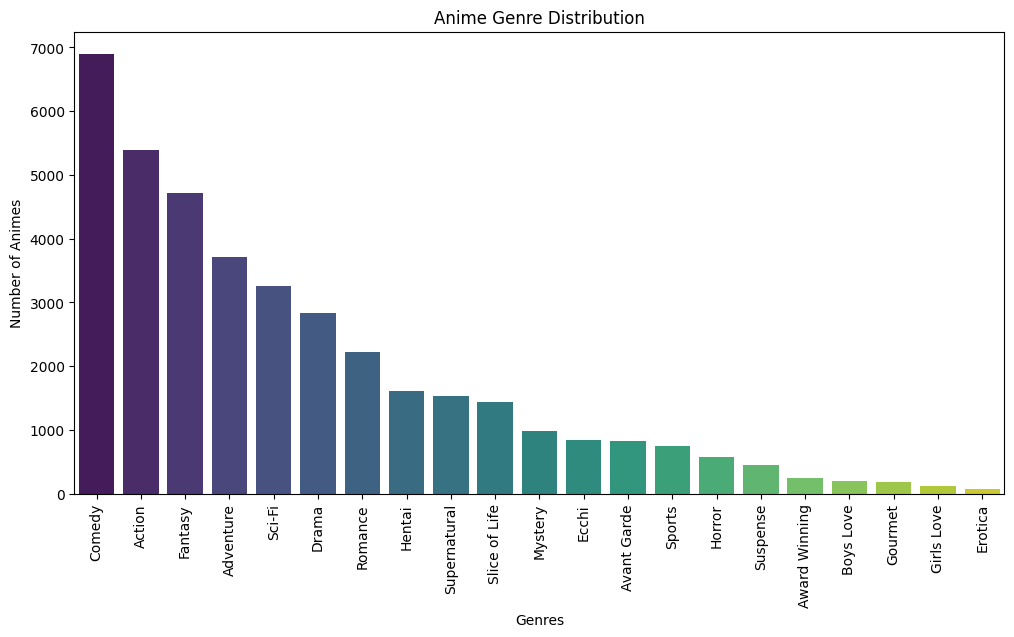

In [ ]:
print("genres count:", genres_series.nunique())
genre_counts = genres_series.value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis',hue = genre_counts.index)
plt.xticks(rotation=90)
plt.title('Anime Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Number of Animes')
plt.show()

detailed genres count: 2990


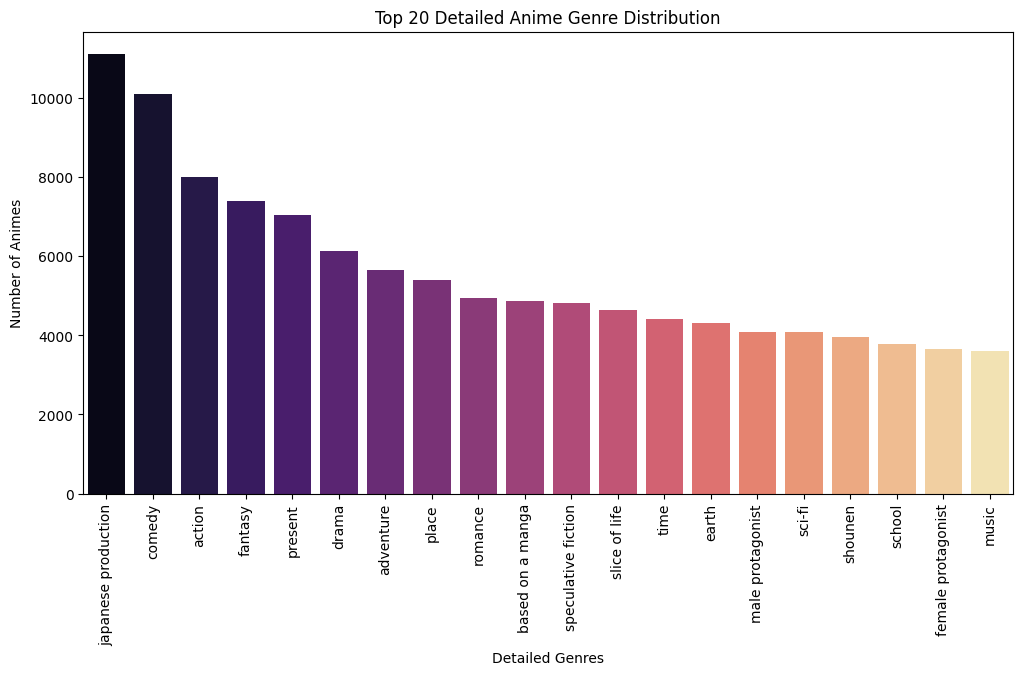

In [ ]:
#detailed geres analysis
genres_series = (anime_df["genres_detailed"]
                 .dropna()
                 .str.strip("[]")  
                 .str.split(', ')  
                 .explode()        
                 .str.strip("'"))
genres_series = pd.Series(genres_series)
print("detailed genres count:", genres_series.nunique())
genre_counts = genres_series.value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma',hue = genre_counts.index)
plt.xticks(rotation=90)
plt.title('Top 20 Detailed Anime Genre Distribution')
plt.xlabel('Detailed Genres')   
plt.ylabel('Number of Animes')
plt.show()


In [ ]:
ratings_df = pd.DataFrame(ratings_df, columns=['user_id', 'anime_id', 'rating'])

#Recasting to more memory efficient dtypes
ratings_df['user_id'] = ratings_df['user_id'].astype('int32')
ratings_df['anime_id'] = ratings_df['anime_id'].astype('int16')  
ratings_df['rating'] = ratings_df['rating'].astype('int8')

print(ratings_df.memory_usage(deep=True))
print(ratings_df.info())
ratings_df.head()

KeyboardInterrupt: 

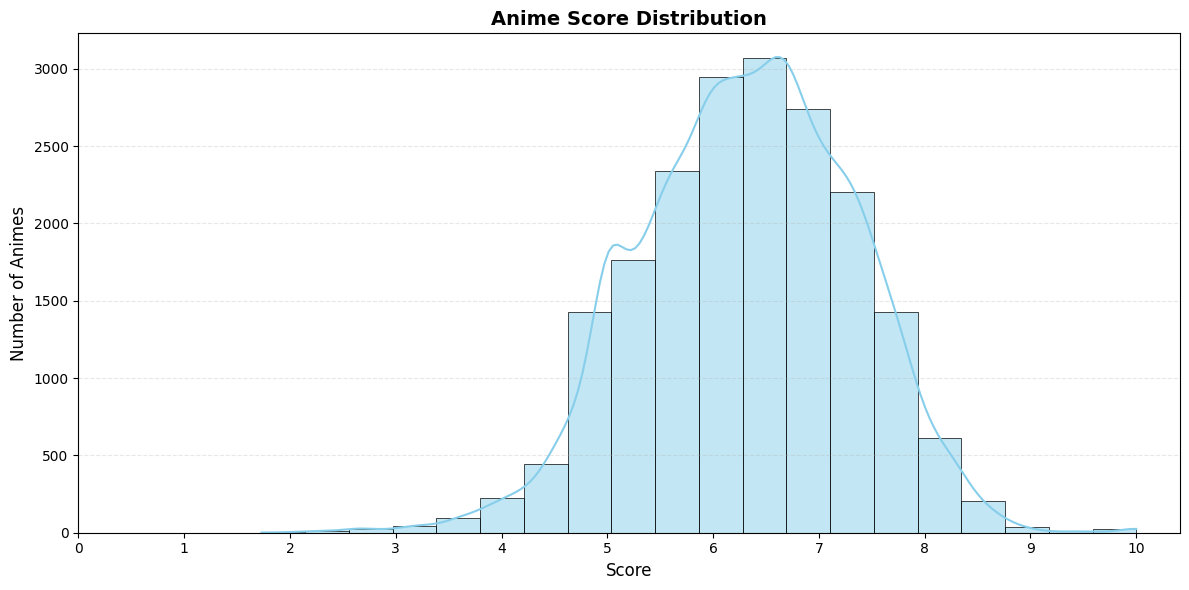

In [ ]:
# Score distribution
score_series = anime_df['score'].dropna().apply(pd.to_numeric, errors='coerce').dropna()
# Score distribution
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(score_series, bins=20, kde=True, 
             color='skyblue', edgecolor='black', linewidth=0.5, ax=ax)
ax.set_title('Anime Score Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Number of Animes', fontsize=12)
ax.set_xticks(np.arange(0, 11, 1))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
#Implement a score per year avg (to see if there is a trend or if newer anime are better scored)

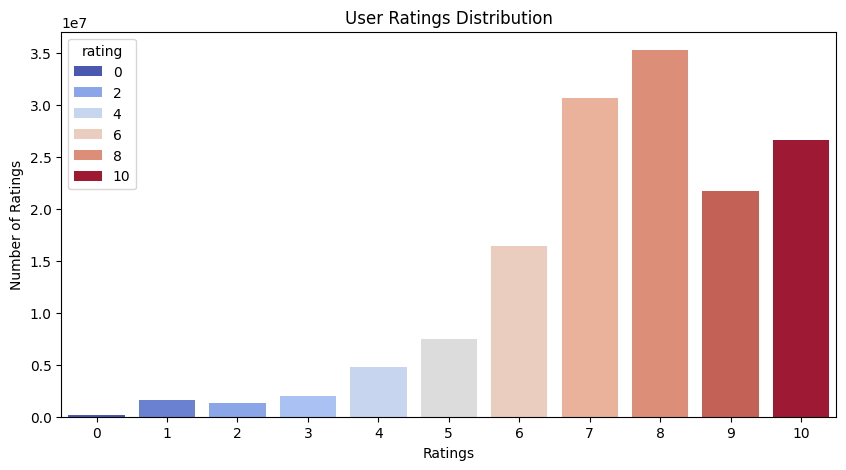

In [ ]:
#ratings analysis
ratings_summary = ratings_df['rating'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=ratings_summary.index, y=ratings_summary.values, palette='coolwarm',hue = ratings_summary.index)
plt.title('User Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

In [ ]:
raise Exception("Stop Execution")

#Most rated/popular animes
most_rated = (ratings_df
              .groupby('anime_id')
              .size()
              .reset_index(name='rating_count'))
top_10_most_rated = most_rated.nlargest(10, 'rating_count')
top_10_most_rated = anime_df[anime_df['animeID'].isin(top_10_most_rated['anime_id'])]

In [ ]:
print(top_10_most_rated[['title']])

                                 title
1                           Death Note
19                     Attack on Titan
91                       One Punch Man
98    Fullmetal Alchemist: Brotherhood
99                    My Hero Academia
1146                        Your Name.
1159          Attack on Titan Season 2
1166         My Hero Academia Season 2
1185         My Hero Academia Season 3
2375    Demon Slayer: Kimetsu no Yaiba


In [ ]:
# Ratings per user distribution
user_rating_counts = ratings_df.groupby('user_id').size()
print(f"Average ratings per user: {user_rating_counts.mean():.2f}")
print(f"Median ratings per user: {user_rating_counts.median():.2f}")

In [ ]:
#TODO : Further EDA and visualizations + implement chunking to optimize memory usage while processing large datasets (or revert to Collab)
#Implement Helper module for repetitive tasks